# Models
In this notebook we will generate several different models using the already engineered features. We will then evaluate the models using cross validation and select the best model to use for our predictions.

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [77]:
GEO = 'texas_florida'
df = pd.read_csv(f'../../data/features/features_{GEO}_pca.csv')
df.index = df["review_id"]
df.drop(columns=["review_id"], inplace=True)

print(df.shape)
df.head()

(1546, 96)


,pca_comments_0,pca_comments_1,pca_comments_2,pca_description_0,pca_description_1,pca_description_2,3gram09_would_not_recommend,3gram09_no_toilet_paper,3gram09_not_recommend_staying,3gram09_write_negative_review,...,amenityall_silverware,amenityall_bathtub,amenityall_lockbox,amenityall_crib,amenityall_elevator,amenityall_gym,amenityall_oven,amenityall_waterfront,amenityall_toilet,label
review_id,,,,,,,,,,,,,,,,,,,,,
83097,-0.05,-0.09,-0.02,0.22,-0.22,0.16,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
133337,-0.15,0.21,-0.03,0.22,-0.22,0.16,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
150928,0.00,-0.11,0.08,0.22,-0.22,0.16,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
2706775,-0.25,-0.14,0.02,0.22,-0.22,0.16,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
8602878,0.04,-0.03,0.01,0.22,-0.22,0.16,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good


In [78]:
df.label.value_counts()

good     1236
mbad      124
mgood     106
bad        80
Name: label, dtype: int64

Drop NA labels... THANKS Charlie :/

In [79]:
df = df.dropna()

The data is extremely imbalanced. We can use the `imbalanced-learn` Python library, which has several implementations of resampling methods to deal with this problem. We will use the `SMOTE` method, which oversamples the minority class.

In [80]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(df.drop(columns=["label"]), df["label"])

print("Balanced labels:")
y.value_counts()

Balanced labels:


good     1236
mgood    1236
mbad     1236
bad      1236
Name: label, dtype: int64

## Testing out different feature combinations
We want to try the different combinations of features to see which ones work best.

In [81]:
import itertools

feature_sets = [
    "pca_comments_",
    "pca_description_",
    "3gram09_",
    "3gram10_",
    "amenity005_",
    "amenityall_"
]

# get all combinations of feature sets of all lengths
feature_sets_combinations = []
for i in range(1, len(feature_sets) + 1):
    feature_sets_combinations += [list(x) for x in itertools.combinations(feature_sets, i)]

print(f"Number of feature sets combinations: {len(feature_sets_combinations)}")

Number of feature sets combinations: 63


In [82]:
from lazypredict.Supervised import LazyClassifier

top_models = {}
best_model = None
best_accuracy = -1
best_feature_set = None

num_of_feature_sets_combinations = len(feature_sets_combinations)

for i, feature_sets_combination in enumerate(feature_sets_combinations):

    print(f"Testing feature sets combination {i + 1} of {num_of_feature_sets_combinations} ({feature_sets_combination})")

    # get column subset
    df_subset_columns = [c for c in df.columns if any([c.startswith(f) for f in feature_sets_combination])]
    df_subset_columns.append("label")

    # oversample and get train/test split
    df_subset = df[df_subset_columns]
    X, y = oversample.fit_resample(df_subset.drop(columns=["label"]), df_subset["label"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train model
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    top_models_for_subset = models.sort_values(by="Accuracy", ascending=False).head(10)

    top_model = models.iloc[0]
    accuracy = top_model["Accuracy"]
    name = top_model.name
    print(f"Top model for {feature_sets_combination}: {name}. Accuracy = {accuracy}")
    if top_model["Accuracy"] > best_accuracy:
        best_accuracy = top_model["Accuracy"]
        best_model = top_model
        best_feature_set = feature_sets_combination
        print(f"New best model found! Accuracy = {accuracy}")

    # save results
    top_models[",".join(feature_sets_combination)] = top_models_for_subset

    print()


print(f"Best model: {best_model.name} with feature set {best_feature_set}\nAccuracy = {best_accuracy}")

import pickle
# save top_models
with open(f"../../models/top_models_{GEO}_midsemester.pickle", "wb") as f:
    pickle.dump(top_models, f)

Testing feature sets combination 1 of 63 (['pca_comments_'])


100%|██████████| 29/29 [00:07<00:00,  3.81it/s]


Top model for ['pca_comments_']: ExtraTreesClassifier. Accuracy = 0.8291203235591507
New best model found! Accuracy = 0.8291203235591507

Testing feature sets combination 2 of 63 (['pca_description_'])


100%|██████████| 29/29 [00:08<00:00,  3.56it/s]


Top model for ['pca_description_']: ExtraTreesClassifier. Accuracy = 0.7633973710819009

Testing feature sets combination 3 of 63 (['3gram09_'])


100%|██████████| 29/29 [00:12<00:00,  2.26it/s]


Top model for ['3gram09_']: SVC. Accuracy = 0.27401415571284127

Testing feature sets combination 4 of 63 (['3gram10_'])


100%|██████████| 29/29 [00:05<00:00,  5.43it/s]


Top model for ['3gram10_']: LGBMClassifier. Accuracy = 0.25884732052578363

Testing feature sets combination 5 of 63 (['amenity005_'])


100%|██████████| 29/29 [00:07<00:00,  3.63it/s]


Top model for ['amenity005_']: ExtraTreeClassifier. Accuracy = 0.3538928210313448

Testing feature sets combination 6 of 63 (['amenityall_'])


100%|██████████| 29/29 [00:12<00:00,  2.36it/s]


Top model for ['amenityall_']: ExtraTreesClassifier. Accuracy = 0.4711830131445905

Testing feature sets combination 7 of 63 (['pca_comments_', 'pca_description_'])


100%|██████████| 29/29 [00:07<00:00,  3.68it/s]


Top model for ['pca_comments_', 'pca_description_']: ExtraTreesClassifier. Accuracy = 0.9302325581395349
New best model found! Accuracy = 0.9302325581395349

Testing feature sets combination 8 of 63 (['pca_comments_', '3gram09_'])


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


Top model for ['pca_comments_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.813953488372093

Testing feature sets combination 9 of 63 (['pca_comments_', '3gram10_'])


100%|██████████| 29/29 [00:08<00:00,  3.50it/s]


Top model for ['pca_comments_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8432760364004045

Testing feature sets combination 10 of 63 (['pca_comments_', 'amenity005_'])


100%|██████████| 29/29 [00:10<00:00,  2.82it/s]


Top model for ['pca_comments_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8584428715874621

Testing feature sets combination 11 of 63 (['pca_comments_', 'amenityall_'])


100%|██████████| 29/29 [00:13<00:00,  2.11it/s]


Top model for ['pca_comments_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8887765419615774

Testing feature sets combination 12 of 63 (['pca_description_', '3gram09_'])


100%|██████████| 29/29 [00:17<00:00,  1.68it/s]


Top model for ['pca_description_', '3gram09_']: BaggingClassifier. Accuracy = 0.7573306370070778

Testing feature sets combination 13 of 63 (['pca_description_', '3gram10_'])


100%|██████████| 29/29 [00:09<00:00,  3.17it/s]


Top model for ['pca_description_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7623862487360971

Testing feature sets combination 14 of 63 (['pca_description_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


Top model for ['pca_description_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.7937310414560161

Testing feature sets combination 15 of 63 (['pca_description_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.83it/s]


Top model for ['pca_description_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8351870576339737

Testing feature sets combination 16 of 63 (['3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:15<00:00,  1.82it/s]


Top model for ['3gram09_', '3gram10_']: SVC. Accuracy = 0.2750252780586451

Testing feature sets combination 17 of 63 (['3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:19<00:00,  1.52it/s]


Top model for ['3gram09_', 'amenity005_']: LGBMClassifier. Accuracy = 0.34984833164812945

Testing feature sets combination 18 of 63 (['3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:24<00:00,  1.19it/s]


Top model for ['3gram09_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.48230535894843274

Testing feature sets combination 19 of 63 (['3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:10<00:00,  2.65it/s]


Top model for ['3gram10_', 'amenity005_']: ExtraTreeClassifier. Accuracy = 0.3690596562184024

Testing feature sets combination 20 of 63 (['3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.73it/s]


Top model for ['3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.4954499494438827

Testing feature sets combination 21 of 63 (['amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Top model for ['amenity005_', 'amenityall_']: DecisionTreeClassifier. Accuracy = 0.49848331648129424

Testing feature sets combination 22 of 63 (['pca_comments_', 'pca_description_', '3gram09_'])


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.9362992922143579
New best model found! Accuracy = 0.9362992922143579

Testing feature sets combination 23 of 63 (['pca_comments_', 'pca_description_', '3gram10_'])


100%|██████████| 29/29 [00:16<00:00,  1.78it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9342770475227502

Testing feature sets combination 24 of 63 (['pca_comments_', 'pca_description_', 'amenity005_'])


100%|██████████| 29/29 [00:14<00:00,  1.98it/s]


Top model for ['pca_comments_', 'pca_description_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9373104145601617
New best model found! Accuracy = 0.9373104145601617

Testing feature sets combination 25 of 63 (['pca_comments_', 'pca_description_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.28it/s]


Top model for ['pca_comments_', 'pca_description_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9433771486349848
New best model found! Accuracy = 0.9433771486349848

Testing feature sets combination 26 of 63 (['pca_comments_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:55<00:00,  1.92s/it]


Top model for ['pca_comments_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8250758341759353

Testing feature sets combination 27 of 63 (['pca_comments_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:56<00:00,  1.94s/it]


Top model for ['pca_comments_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8543983822042467

Testing feature sets combination 28 of 63 (['pca_comments_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:55<00:00,  1.93s/it]


Top model for ['pca_comments_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8665318503538928

Testing feature sets combination 29 of 63 (['pca_comments_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


Top model for ['pca_comments_', '3gram10_', 'amenity005_']: RandomForestClassifier. Accuracy = 0.8827098078867543

Testing feature sets combination 30 of 63 (['pca_comments_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:38<00:00,  1.31s/it]


Top model for ['pca_comments_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8645096056622852

Testing feature sets combination 31 of 63 (['pca_comments_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Top model for ['pca_comments_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8665318503538928

Testing feature sets combination 32 of 63 (['pca_description_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:44<00:00,  1.53s/it]


Top model for ['pca_description_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7704752275025278

Testing feature sets combination 33 of 63 (['pca_description_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:52<00:00,  1.79s/it]


Top model for ['pca_description_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.7937310414560161

Testing feature sets combination 34 of 63 (['pca_description_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


Top model for ['pca_description_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8270980788675429

Testing feature sets combination 35 of 63 (['pca_description_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Top model for ['pca_description_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.7977755308392316

Testing feature sets combination 36 of 63 (['pca_description_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:38<00:00,  1.34s/it]


Top model for ['pca_description_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.833164812942366

Testing feature sets combination 37 of 63 (['pca_description_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:47<00:00,  1.64s/it]


Top model for ['pca_description_', 'amenity005_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.8129423660262892

Testing feature sets combination 38 of 63 (['3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:46<00:00,  1.61s/it]


Top model for ['3gram09_', '3gram10_', 'amenity005_']: LGBMClassifier. Accuracy = 0.3619817997977755

Testing feature sets combination 39 of 63 (['3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:57<00:00,  1.98s/it]


Top model for ['3gram09_', '3gram10_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.49848331648129424

Testing feature sets combination 40 of 63 (['3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Top model for ['3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.46309403437815977

Testing feature sets combination 41 of 63 (['3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.71it/s]


Top model for ['3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.48432760364004046

Testing feature sets combination 42 of 63 (['pca_comments_', 'pca_description_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9271991911021233

Testing feature sets combination 43 of 63 (['pca_comments_', 'pca_description_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.942366026289181

Testing feature sets combination 44 of 63 (['pca_comments_', 'pca_description_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9292214357937311

Testing feature sets combination 45 of 63 (['pca_comments_', 'pca_description_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:08<00:00,  3.53it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9261880687563195

Testing feature sets combination 46 of 63 (['pca_comments_', 'pca_description_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9342770475227502

Testing feature sets combination 47 of 63 (['pca_comments_', 'pca_description_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Top model for ['pca_comments_', 'pca_description_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9322548028311426

Testing feature sets combination 48 of 63 (['pca_comments_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:14<00:00,  2.00it/s]


Top model for ['pca_comments_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8533872598584429

Testing feature sets combination 49 of 63 (['pca_comments_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.72it/s]


Top model for ['pca_comments_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.871587462082912

Testing feature sets combination 50 of 63 (['pca_comments_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.57it/s]


Top model for ['pca_comments_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8725985844287159

Testing feature sets combination 51 of 63 (['pca_comments_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Top model for ['pca_comments_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8756319514661274

Testing feature sets combination 52 of 63 (['pca_description_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Top model for ['pca_description_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.7987866531850354

Testing feature sets combination 53 of 63 (['pca_description_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:20<00:00,  1.45it/s]


Top model for ['pca_description_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8382204246713852

Testing feature sets combination 54 of 63 (['pca_description_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Top model for ['pca_description_', '3gram09_', 'amenity005_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.8068756319514662

Testing feature sets combination 55 of 63 (['pca_description_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  1.99it/s]


Top model for ['pca_description_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8321536905965622

Testing feature sets combination 56 of 63 (['3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Top model for ['3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.5187057633973711

Testing feature sets combination 57 of 63 (['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:16<00:00,  1.80it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9373104145601617

Testing feature sets combination 58 of 63 (['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.53it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9271991911021233

Testing feature sets combination 59 of 63 (['pca_comments_', 'pca_description_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9373104145601617

Testing feature sets combination 60 of 63 (['pca_comments_', 'pca_description_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.88it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9433771486349848

Testing feature sets combination 61 of 63 (['pca_comments_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Top model for ['pca_comments_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8412537917087968

Testing feature sets combination 62 of 63 (['pca_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.23it/s]


Top model for ['pca_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8270980788675429

Testing feature sets combination 63 of 63 (['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:24<00:00,  1.18it/s]

Top model for ['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9312436804853387

Best model: ExtraTreesClassifier with feature set ['pca_comments_', 'pca_description_', 'amenityall_']
Accuracy = 0.9433771486349848


# Examine Top models

In [96]:
import pickle
top_models = pickle.load(open(f"../../models/top_models_{GEO}_midsemester.pickle", "rb"))

report = []

feature_set_to_letter = {
    "pca_comments_": "(A)",
    "pca_description_": "(B)",
    "amenity005_" : "(C)",
    "amenityall_" : "(D)",
    "3gram09_" : "(E)",
    "3gram10_" : "(F)",
    
}

# iterate over keys and values
for key, value in top_models.items():
    top_model_name = value.iloc[0].name
    top_model_accuracy = value.iloc[0]["Accuracy"]

    report.append({
        "feature_set": ", ".join([feature_set_to_letter[f] for f in key.split(",")]),
        "top_model_name": top_model_name,
        "top_model_accuracy": top_model_accuracy
    })

top = pd.DataFrame(report).sort_values(by="top_model_accuracy", ascending=False)
top.head(10)

,feature_set,top_model_name,top_model_accuracy
59,"(A), (B), (F), (C), (D)",ExtraTreesClassifier,0.94
24,"(A), (B), (D)",ExtraTreesClassifier,0.94
42,"(A), (B), (E), (C)",ExtraTreesClassifier,0.94
58,"(A), (B), (E), (C), (D)",ExtraTreesClassifier,0.94
56,"(A), (B), (E), (F), (C)",ExtraTreesClassifier,0.94
23,"(A), (B), (C)",ExtraTreesClassifier,0.94
21,"(A), (B), (E)",ExtraTreesClassifier,0.94
22,"(A), (B), (F)",ExtraTreesClassifier,0.93
45,"(A), (B), (F), (D)",ExtraTreesClassifier,0.93
46,"(A), (B), (C), (D)",ExtraTreesClassifier,0.93


Let's see which features appear the most in models that perform over 80% accuracy.

There are 16 models above 90% accuracy


<AxesSubplot: xlabel='% of top models using feature set', ylabel='Feature set'>

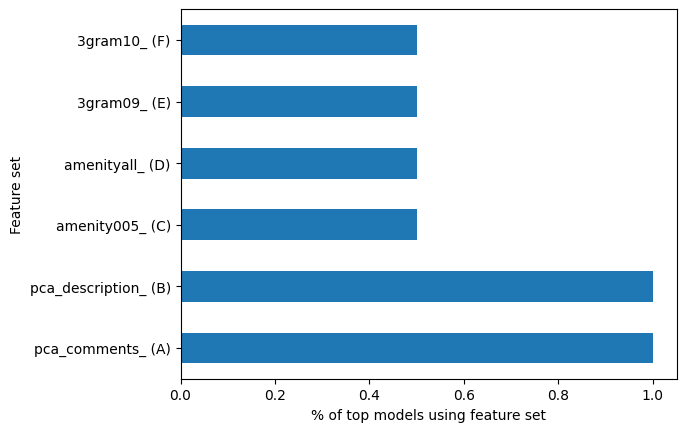

In [97]:
# split feature_set into individual feature sets
letters = ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)"]
top["feature_set_split"] = top["feature_set"].apply(lambda x: x.split(", "))
for letter in ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)"]:
    top[letter] = top["feature_set_split"].apply(lambda x: letter in x)

# lets see what percent of the top models have each feature set (top models will be above 80% accuracy)
with_accuracy = top[["top_model_accuracy"] + letters]
models_above_90_accuracy = with_accuracy[with_accuracy.top_model_accuracy > 0.9]
print(f"There are {models_above_90_accuracy.shape[0]} models above 90% accuracy")
feature_set_distr = models_above_90_accuracy.sum().drop("top_model_accuracy").sort_values(ascending=False) / models_above_90_accuracy.shape[0]


# convert back to feature set name
# reverse feature_set_to_letter
feature_set_to_letter = {v: k for k, v in feature_set_to_letter.items()}
feature_set_distr.index = feature_set_distr.index.map(lambda x: feature_set_to_letter[x] + " " + x)
feature_set_distr.plot(kind="barh", xlabel="% of top models using feature set", ylabel="Feature set")

Let's use the top 3 features that appear the most in the best models.

In [111]:
top_feature_set = ["pca_comments_", "pca_description_", "amenity005_"]

In [112]:

columns_in_best_feature_set = [c for c in df.columns if any([c.startswith(f) for f in top_feature_set])]
columns_in_best_feature_set.append("label")

df_best_subset = df[columns_in_best_feature_set]

print("Best feature set:")
print(columns_in_best_feature_set)


Best feature set:
['pca_comments_0', 'pca_comments_1', 'pca_comments_2', 'pca_description_0', 'pca_description_1', 'pca_description_2', 'amenity005_lockbox', 'amenity005_dishwasher', 'amenity005_pool', 'amenity005_keypad', 'amenity005_tv', 'amenity005_stove', 'amenity005_bathtub', 'amenity005_balcony', 'amenity005_shampoo', 'amenity005_garden', 'amenity005_cat', 'amenity005_family', 'amenity005_breakfast', 'label']


Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best parameters:
{'leaf_size': 10, 'n_neighbors': 3}
Accuracy: 0.87


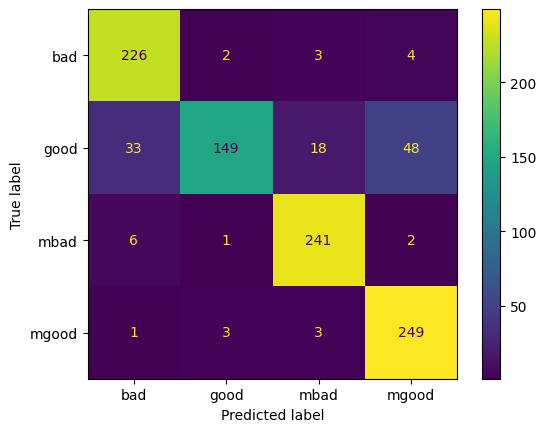

In [109]:
from sklearn.neighbors import KNeighborsClassifier

# apply GridSearchCV to find the best parameters
from sklearn.model_selection import GridSearchCV

# params for KNC
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15],
    "leaf_size": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
}

clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1, verbose=1)

# oversample and get train/test split
X, y = oversample.fit_resample(df_best_subset.drop(columns=["label"]), df_best_subset["label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# print the best parameters
print("Best parameters:")
print(clf.best_params_)

# predict
y_pred = best_clf.predict(X_test)

# evaluate
from sklearn.metrics import accuracy_score

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [106]:
import plotly.express as px

best_params = clf.best_params_

# build model
etc = KNeighborsClassifier(**best_params)

# run with 1 to 10 fold cv and plot the train and test accuracy for each
from sklearn.model_selection import cross_validate

all_scores = []

for cv in range(2, 12):
    scores = cross_validate(etc, X, y, cv=cv, scoring="accuracy", return_train_score=True)
    print(f"CV = {cv}:\n\tTrain accuracy = {round(scores['train_score'].mean(), 2)}\n\tTest accuracy = {round(scores['test_score'].mean(), 2)}")
    all_scores.append({
        "folds": cv,
        "train_accuracy": scores["train_score"].mean(),
        "test_accuracy": scores["test_score"].mean()
    })


# plot the results
all_scores_df = pd.DataFrame.from_dict(all_scores)
px.line(all_scores_df, x="folds", y=["train_accuracy", "test_accuracy"], title="Train and test accuracy for different number of folds")

CV = 2:
	Train accuracy = 0.93
	Test accuracy = 0.83
CV = 3:
	Train accuracy = 0.93
	Test accuracy = 0.85
CV = 4:
	Train accuracy = 0.94
	Test accuracy = 0.86
CV = 5:
	Train accuracy = 0.94
	Test accuracy = 0.87
CV = 6:
	Train accuracy = 0.94
	Test accuracy = 0.87
CV = 7:
	Train accuracy = 0.94
	Test accuracy = 0.87
CV = 8:
	Train accuracy = 0.94
	Test accuracy = 0.87
CV = 9:
	Train accuracy = 0.94
	Test accuracy = 0.87
CV = 10:
	Train accuracy = 0.94
	Test accuracy = 0.88
CV = 11:
	Train accuracy = 0.94
	Test accuracy = 0.88


# Save the model along with functions to generate features

In [110]:
pickle.dump({
    "best_clf": best_clf,
    "best_feature_set": columns_in_best_feature_set,
}, open(f"../../models/best_clf_{GEO}_midsemester.pickle", "wb"))